## React Agent

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs

load_env()

True

In [ ]:
from typing import Literal,Optional
from pydantic import BaseModel
from pprint import pprint

from stringdale import Define,V,E, Condition
from stringdale.chat import Chat
from stringdale.tools import wikipedia_search,run_python_code


In [ ]:
react_system_prompt = [{'role':'system','content':"""
Answer the following questions as best you can.
Here is an example of the format of the answer:
Question: the input question you must answer
Thought: you should always think about what to do
Tool Name: the name of the tool you will use
Tool Input: the input to the tool
Observation: the result of the tool
This thought - tool name - tool input - observation can repeat N times
Final Answer: the final answer to the original input question
Each time you are prompter either provide a thought that you need to use a tool or provide a final answer.
the tool name, input and observation will be provided to you in the next message.

Example:
user:
Question: what is the year five years from now?
assistant:
Thought: I need to compute the current year
Tool Name: wikipedia_search
Tool Input: {query: 'what is the current year'}
Observation: 2024
Thought: I need to add 5 to the current year
Tool Name: run_python_code
Tool Input: {code: 'import datetime; result = datetime.datetime.now().year + 5',output_expression='result'}
Observation: 2029
Final Answer: 2029
"""}]


class Thought(BaseModel):
    type: Literal['thought','final_answer']
    text: str

react_cot_chat = Chat(model='gpt-4o-mini',
    save_history=True,
    init_messages=react_system_prompt,
    output_schema=Thought,
    )
react_cot_chat

Chat(model='gpt-4o-mini', output_schema=Thought, seed=42, save_history=True)

In [ ]:
res = await react_cot_chat(messages=[{'role':'user','content':'Question: what is obamas age to the power of 2?'}])
res

{'role': 'assistant',
 'content': Thought(type='thought', text="I need to find out Obama's current age."),
 'meta': {'input_tokens': 433, 'output_tokens': 23}}

In [ ]:
tools = {
    'wikipedia_search':wikipedia_search,
    'run_python_code':run_python_code,
}


react_tool_step = Chat(model='gpt-4o-mini',
    messages= [
        {'role':'system','content':'choose an appropriate tool to use to answer the following:'},
        {'role':'user','content':'{{thought}}'}],
    tools=tools,
    call_function=True
    )
await react_tool_step(thought='what is the capital of france?')

{'role': 'assistant',
 'content': {'name': 'wikipedia_search',
  'input': {'q': 'capital of France'},
  'output': "This is a chronological list of capitals of France. The capital of France has been Paris since its liberation in 1944.\n\n\n== Chronology ==\nTournai (before 486), current-day Belgium\nSoissons (486–936)\nLaon (936–987)\nParis (987–1419), the residence of the Kings of France, although they were consecrated at Reims.\nOrléans (1108), one of the few consecrations of a French monarch to occur outside of Reims occurred at Orléans, when Louis VI the Fat was consecrated in Orléans Cathedral by Daimbert, Archbishop of Sens; from 13 December 1560 to 31 January 1561, the French States-General also met in the city.\nTroyes (1419–1422), for a short time during the Hundred Years' War, the city was the seat of the royal government.\nBourges (1422–1444), Charles VII was forced to flee from Paris.\nTours (1444–1527), Louis XI made the Château de Plessis-lez-Tours his residence.\nParis (1

In [ ]:
await react_tool_step(thought='what is the square root of 16?')


{'role': 'assistant',
 'content': {'name': 'run_python_code',
  'input': {'code': '16**0.5'},
  'output': 4.0},
 'meta': {'input_tokens': 683, 'output_tokens': 31}}

In [ ]:
def react_cot_format(tool_name,input,output):
    return [{
        'role':'assistant',
        'content':f"""Tool Name: {tool_name}
Tool Input: {input}
Observation: {output}"""
    }]

is_final_answer= Condition('final_answer','(0=content.type)',name='is_final_answer')

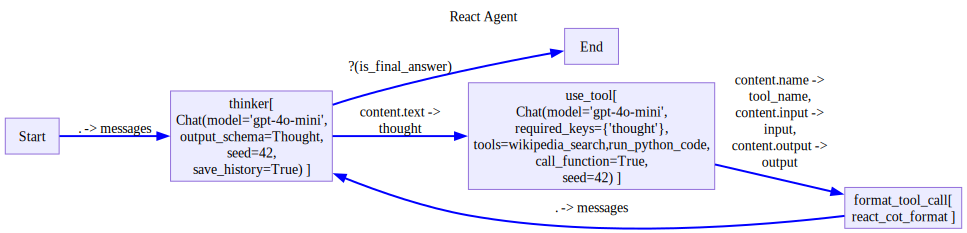

In [ ]:
with Define('React Agent',type='decision') as ReactAgent:

    V('thinker',react_cot_chat,
        inputs = ['Start(messages)'],
        outputs = [
            ('End',is_final_answer),
            'use_tool(thought=content.text)'])
    V('use_tool',react_tool_step,outputs=['format_tool_call(tool_name=content.name,input=content.input,output=content.output)'])
    V('format_tool_call',react_cot_format,
        outputs =[
            'thinker(messages)'
        ])
ReactAgent.draw()

In [ ]:
d=ReactAgent()
for trace in d.run([{'role':'user','content':"Question: what is obamas age to the power of 2?"}]):
    pass
d.output


{'role': 'assistant',
 'content': Thought(type='final_answer', text='3969'),
 'meta': {'input_tokens': 18029, 'output_tokens': 18}}

In [ ]:
d['thinker'].history

[{'role': 'system',
  'content': 'Answer the following questions as best you can.\nHere is an example of the format of the answer:\nQuestion: the input question you must answer\nThought: you should always think about what to do\nTool Name: the name of the tool you will use\nTool Input: the input to the tool\nObservation: the result of the tool\nThis thought - tool name - tool input - observation can repeat N times\nFinal Answer: the final answer to the original input question\nEach time you are prompter either provide a thought that you need to use a tool or provide a final answer.\nthe tool name, input and observation will be provided to you in the next message.\n\nExample:\nuser:\nQuestion: what is the year five years from now?\nassistant:\nThought: I need to compute the current year\nTool Name: wikipedia_search\nTool Input: {query: \'what is the current year\'}\nObservation: 2024\nThought: I need to add 5 to the current year\nTool Name: run_python_code\nTool Input: {code: \'import d